In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.stats as stats
from tqdm import tqdm

# use the latest inference_interface to allow 1d hist!
sys.path.insert(0, "/home/yuem/xenon_package/inference_interface")
sys.path.insert(0, "/home/yuem/xenon_package/blueice")
from inference_interface import multihist_to_template, template_to_multihist
from alea.utils import get_file_path
from alea.models import BlueiceExtendedModel

In [ ]:
import yaml

example_model_config_path = get_file_path("binned_ces.yaml")
with open(example_model_config_path, "r") as f:
    example_model_config = yaml.load(f, Loader=yaml.FullLoader)
example_model_config["likelihood_config"]

{'template_folder': None,
 'likelihood_terms': [{'name': 'science_run_0',
   'default_source_class': 'alea.ces_source.CESTemplateSource',
   'likelihood_type': 'blueice.likelihood.BinnedLogLikelihood',
   'analysis_space': [{'ces': 'np.arange(0, 500, 1)'}],
   'apply_efficiency': True,
   'efficiency_model': 'constant',
   'efficiency_parameters': ['efficiency_constant'],
   'apply_smearing': True,
   'smearing_model': 'gaussian',
   'smearing_parameters': ['smearing_a', 'smearing_b'],
   'apply_bias': False,
   'livetime_parameter': 'livetime',
   'slice_args': {},
   'source_wise_interpolation': False,
   'sources': [{'name': 'xe133',
     'histname': 'xe133_template',
     'parameters': ['xe133_rate_multiplier',
      'smearing_a',
      'smearing_b',
      'efficiency_constant'],
     'template_filename': 'xe133_template.ii.h5'},
    {'name': 'test_gaussian',
     'class': 'alea.ces_source.CESMonoenergySource',
     'peak_energy': 300,
     'parameters': ['test_gaussian_rate_multip

In [3]:
example_model = BlueiceExtendedModel.from_config(example_model_config_path)

{'name': 'science_run_0', 'default_source_class': 'alea.ces_source.CESTemplateSource', 'likelihood_type': 'blueice.likelihood.BinnedLogLikelihood', 'analysis_space': [{'ces': 'np.arange(0, 500, 1)'}], 'apply_efficiency': True, 'efficiency_model': 'constant', 'efficiency_parameters': ['efficiency_constant'], 'apply_smearing': True, 'smearing_model': 'gaussian', 'smearing_parameters': ['smearing_a', 'smearing_b'], 'apply_bias': False, 'livetime_parameter': 'livetime', 'slice_args': {}, 'source_wise_interpolation': False, 'sources': [{'name': 'xe133', 'histname': 'xe133_template', 'parameters': ['xe133_rate_multiplier', 'smearing_a', 'smearing_b', 'efficiency_constant'], 'template_filename': 'xe133_template.ii.h5'}, {'name': 'test_gaussian', 'class': 'alea.ces_source.CESMonoenergySource', 'peak_energy': 300, 'parameters': ['test_gaussian_rate_multiplier', 'smearing_a', 'smearing_b', 'efficiency_constant']}, {'name': 'test_flat', 'class': 'alea.ces_source.CESFlatSource', 'parameters': ['te

Building histogram
Building histogram


Computing/loading models on one core:   0%|          | 0/2 [00:00<?, ?it/s]

Building histogram
Building histogram
Building histogram


Computing/loading models on one core:  50%|█████     | 1/2 [00:06<00:06,  6.22s/it]

Building histogram
Building histogram
Building histogram


building data generators: 100%|██████████| 1/1 [00:00<00:00, 358.79it/s]


In [4]:
example_model.get_expectation_values()

{'test_flat': 999.9999999999999, 'test_gaussian': 300.0, 'xe133': 1000.0}

In [5]:
# n_model_events
example_model.likelihood_list[0].n_model_events

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
#ps: pmf grid (binned)
example_model.likelihood_list[0].ps

array([[9.04773443e-007, 1.70022150e-006, 1.44361290e-006, ...,
        2.22874512e-016, 1.23613836e-016, 6.80635389e-017],
       [1.70928755e-266, 9.90163184e-265, 5.65851486e-263, ...,
        6.90529806e-116, 4.76078521e-117, 3.23801449e-118],
       [2.03167054e-003, 2.02884836e-003, 2.02791341e-003, ...,
        1.15496934e-003, 1.09184961e-003, 1.02823755e-003]])

In [7]:
example_model.likelihood_list[0].base_model.expected_events()

array([1., 1., 1.])

In [8]:
#mus: rate for each source
example_model.likelihood_list[0]._compute_single_pdf()

(array([1., 1., 1.]),
 array([[9.04773443e-007, 1.70022150e-006, 1.44361290e-006, ...,
         2.22874512e-016, 1.23613836e-016, 6.80635389e-017],
        [1.70928755e-266, 9.90163184e-265, 5.65851486e-263, ...,
         6.90529806e-116, 4.76078521e-117, 3.23801449e-118],
        [2.03167054e-003, 2.02884836e-003, 2.02791341e-003, ...,
         1.15496934e-003, 1.09184961e-003, 1.02823755e-003]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

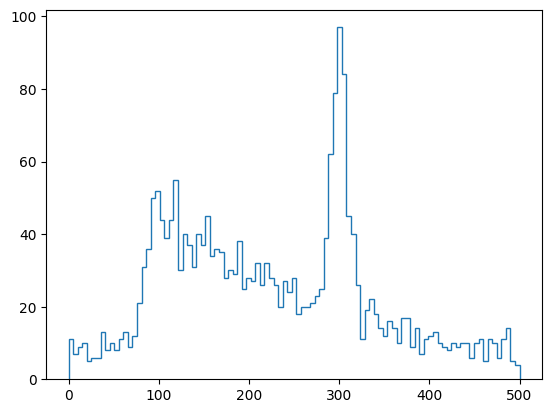

In [9]:
data = example_model.generate_data()
example_model.data = data
plt.hist(data["science_run_0"]["ces"], bins=np.linspace(0, 500, 100), histtype="step")
plt.show()

In [10]:
best_fit, max_ll = example_model.fit()
best_fit

{'livetime': 365.0,
 'xe133_rate_multiplier': 1033.490760614393,
 'test_flat_rate_multiplier': 954.6427541651263,
 'test_gaussian_rate_multiplier': 328.88660448450196,
 'smearing_a': 24.8,
 'smearing_b': 1.429,
 'efficiency_constant': 0.8091246788074896}

In [11]:
fitted_gs_rate = best_fit["test_gaussian_rate_multiplier"]
gs_rates = np.linspace(0.8 * fitted_gs_rate, 1.2 * fitted_gs_rate, 20)
ll_vals_c = np.zeros((len(gs_rates)))

for i, gs_rate in tqdm(enumerate(gs_rates)):
    _, ll_val_c = example_model.fit(test_gaussian_rate_multiplier=gs_rate)
    ll_vals_c[i] = ll_val_c

20it [00:01, 11.67it/s]


Text(0, 0.5, 'q(s)')

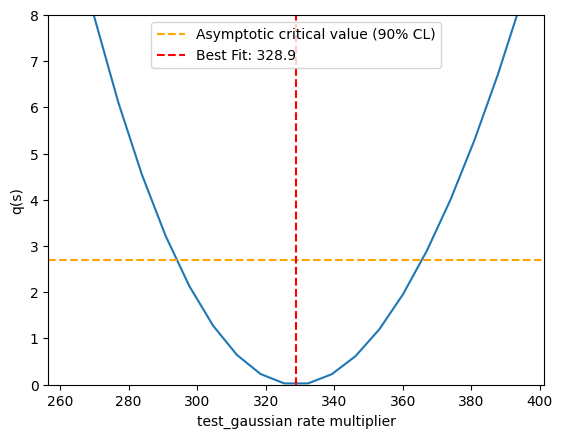

In [12]:
x = gs_rates
y = 2 * (max_ll - ll_vals_c)
confidence_level = 0.9
# Plot
plt.plot(x, y)
plt.axhline(
    stats.chi2(1).ppf(confidence_level),
    label="Asymptotic critical value (90% CL)",
    c="orange",
    ls="--",
)

plt.axvline(fitted_gs_rate, label=f"Best Fit: {fitted_gs_rate:.1f}", c="red", ls="--")
plt.ylim(0, 8)
plt.legend()
plt.xlabel("test_gaussian rate multiplier")
plt.ylabel("q(s)")